In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th

from cnn import CNN
from torch.utils.data import DataLoader
from tqdm import tqdm

from imgdata import DefaultTestSet

In [10]:
%matplotlib inline

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
# load models
lr = [1e-2, 1e-3, 1e-4, 1e-5]
class_label = ['faces', 'dog', 'airplanes', 'keyboard', 'cars']
models = [th.load(f'Outputs/models/model_20_epochs_learning_rate_{i}.pth', map_location=device) for i in lr]

# load test set and create dataloader
test_set = DefaultTestSet()
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
test_y = [i['label'] for i in test_set]

### Inference from test set for each model

In [12]:
# get predictions
def predict(model, _tests):
  predicts = []
  with th.no_grad():
    for i in tqdm(_tests):
      model.eval()
      images = i['imNorm'].clone().to(device)
      outputs = model(images)
      _, predicted = th.max(outputs.data, 1)
      predicts.append(predicted.item())
  return predicts

predictions = []
for i, m in enumerate(models):
  cnn = CNN()
  cnn.load_state_dict(m)
  predictions.append(predict(cnn, test_loader))

100%|██████████| 50/50 [00:00<00:00, 71.39it/s]


### Evaluate predictions

In [13]:
# store the index of correct predictions
correct_list = []
incorrect_list = []
for p in predictions:
  correct = []
  incorrect = []
  for i, j in enumerate(p):
    if j == test_y[i]:
      correct.append(i)
    else:
      incorrect.append(i)
  correct_list.append(correct)
  incorrect_list.append(incorrect)

In [14]:
# generate confusion matrix
def confusion_matrix(y_true, y_pred):
  n_class = np.unique(y_true).shape[0]
  cm = np.zeros((n_class, n_class))
  for i in range(len(y_true)):
    cm[y_true[i], y_pred[i]] += 1
  return cm

cm_list = []
for i in range(len(predictions)):
  cm_list.append(confusion_matrix(test_y, predictions[i]))

# print accuracy by class from confusion matrix
def print_accuracy(cm):
  for i in range(5):
    print(f'the accuracy by class {class_label[i]} : {cm[i, i] / np.sum(cm[i, :])}')
  # overall accuracy
  print(f'overall accuracy : {np.sum(cm[range(5), range(5)]) / np.sum(cm)}')

for i in range(len(cm_list)):
  print(f'learning rate : {lr[i]}')
  print_accuracy(cm_list[i])
  print('-'*50)

learning rate : 0.01
the accuracy by class faces : 0.5
the accuracy by class dog : 0.8
the accuracy by class airplanes : 0.7
the accuracy by class keyboard : 0.2
the accuracy by class cars : 0.9
overall accuracy : 0.62
--------------------------------------------------
learning rate : 0.001
the accuracy by class faces : 0.5
the accuracy by class dog : 0.9
the accuracy by class airplanes : 0.5
the accuracy by class keyboard : 0.2
the accuracy by class cars : 0.7
overall accuracy : 0.56
--------------------------------------------------
learning rate : 0.0001
the accuracy by class faces : 0.8
the accuracy by class dog : 0.8
the accuracy by class airplanes : 0.7
the accuracy by class keyboard : 0.6
the accuracy by class cars : 1.0
overall accuracy : 0.78
--------------------------------------------------
learning rate : 1e-05
the accuracy by class faces : 0.6
the accuracy by class dog : 0.6
the accuracy by class airplanes : 0.7
the accuracy by class keyboard : 0.7
the accuracy by class ca

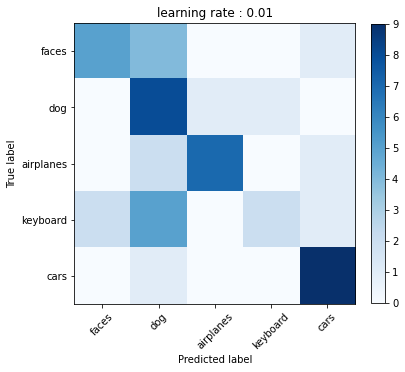

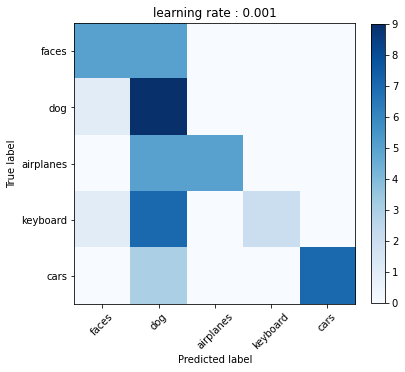

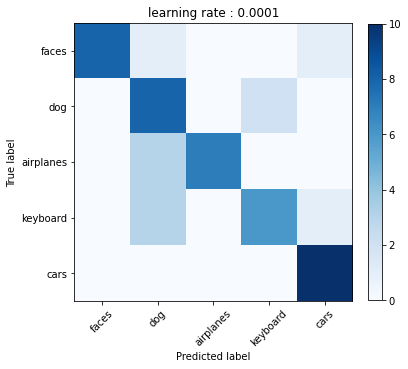

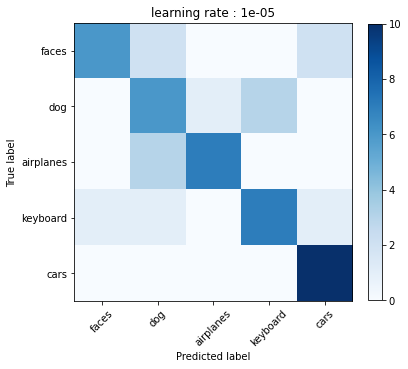

In [15]:
# plot confusion matrix
def plot_cm(cm, title, cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar(fraction=0.045)
  tick_marks = np.arange(len(class_label))
  plt.xticks(tick_marks, class_label, rotation=45)
  plt.yticks(tick_marks, class_label)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

for i in range(len(cm_list)):
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 2, i+1)
  plot_cm(cm_list[i], f'learning rate : {lr[i]}')
  plt.savefig(f'Outputs/cm_learning_rate_{lr[i]}.png')
  plt.show()

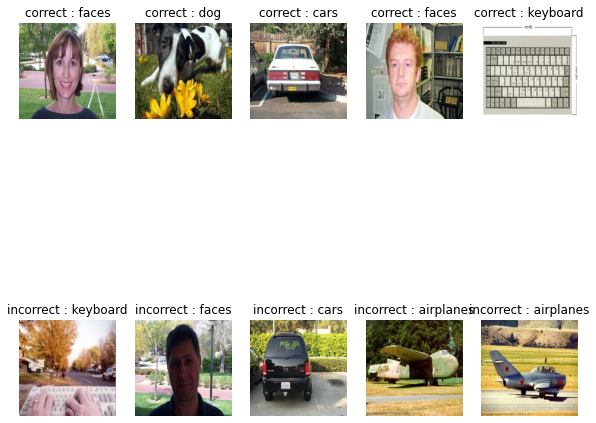

learning rate : 0.01


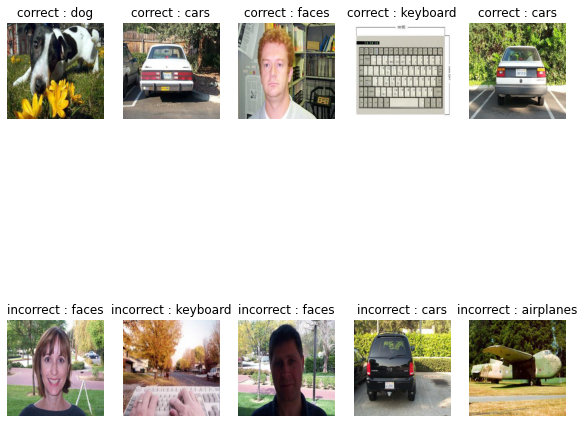

learning rate : 0.001


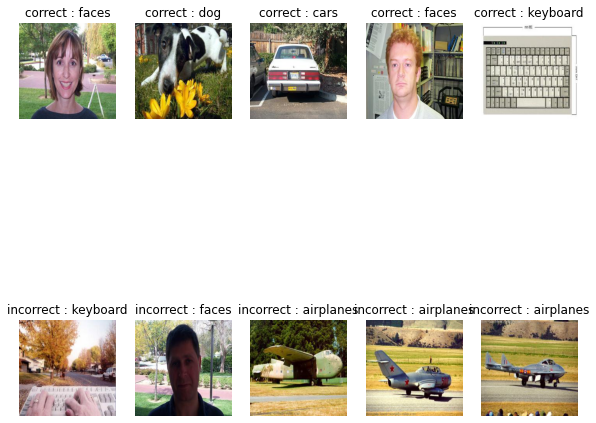

learning rate : 0.0001


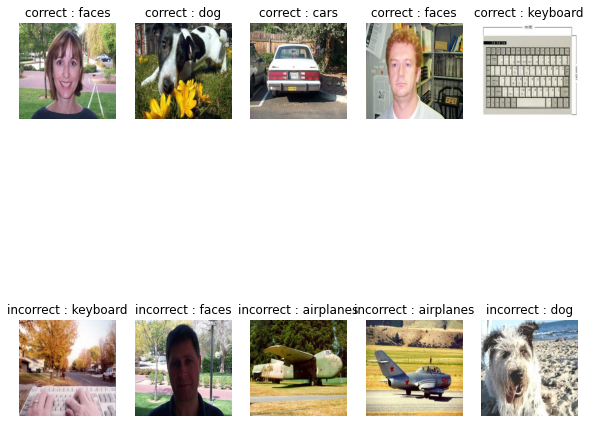

learning rate : 1e-05


In [16]:
import os
from skimage import io

# show some correct and incorrect images
def show_correct_incorrect(correct, incorrect, test_set, num_show = 5):
  if len(correct) < num_show:
    num_show = len(correct)
  if len(incorrect) < num_show:
    num_show = len(incorrect)

  for i in range(num_show):
    plt.subplot(2, num_show, i+1)
    plt.axis('off')
    plt.imshow(io.imread(os.path.join(test_set.root_dir, test_set.imPath[correct[i]])), cmap='gray')
    plt.title(f'correct : {class_label[test_set[correct[i]]["label"]]}')
    plt.subplot(2, num_show, i+1+num_show)
    plt.axis('off')
    plt.imshow((io.imread(os.path.join(test_set.root_dir, test_set.imPath[incorrect[i]]))), cmap='gray')
    plt.title(f'incorrect : {class_label[test_set[incorrect[i]]["label"]]}')
  plt.show()

for i in range(len(lr)):
  plt.figure(figsize=(10, 10))
  show_correct_incorrect(correct_list[i], incorrect_list[i], test_set)
  print(f'learning rate : {lr[i]}')